#**Codes initiaux**

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/MyDrive/"

def save_df(df, filename):
  df.to_csv(root_path + filename)

def load_df(filename):
  return pd.read_csv(root_path + filename, header=0, index_col=0)

#Chargement des données
df_wh = load_df("df_world_happiness")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1 - Contexte et début de la modélisation**



##**1 - a) Rappel**


Pour rappel, ce projet consiste à effectuer une analyse approfondie des données collectées par le World Happiness Report. 

L'objectif pour cette seconde partie est donc de créer un modèle pour prédire les données pour l'année 2022.

Pour cela et pour nous rapprocher au mieux des nouvelles valeurs du rapport 2022, nous devons donc découvrir les variables qui influencent notre valeur cible 'Life Ladder', pour obtenir un modèle de prédiction au plus proche de la réalité.




Pour cette partie modélisation, il existe une large variété d’algorithmes de Machine Learning. Ici, puisque nous disposons d'une variable cible 'Life Ladder', nous sommes donc dans un **modèle d'apprentissage supervisé**. 

Pour rappel, l'apprentissage supervisé, à partir de données labellisées (dites aussi étiquetées), cherche à prédire cette variable cible. On a à disposition des variables explicatives et on veut prédire l'information contenue dans la variable cible. Les données disponibles sont labellisées, cela signifie que l'on connaît la valeur de la variable cible pour ces données. Cela est nécessaire pour permettre au modèle de s'entraîner et d'apprendre sur les données. 

L'apprentissage supervisé peut être divisé en deux principales techniques, permettant de comprendre les relations entre les données :
* **La régression** : On cherche à prédire une variable de type quantitatif.
* **La classification** : On cherche à prédire une variable de type qualitatif.

Ici, notre variable cible 'Life Ladder' est le résultat d'un score, que nous pouvons considérer comme une **variable continue**. Par conséquent, nous pourrons utiliser des **algorithmes de régression**.



##**1 - b) Premiers essais et création d'une pipeline**

Comme expliqué précédemment, nous souhaitions commencer nos premières tentatives sur des modèles de régression simples. 

Après plusieurs entraînements, nous nous sommes rendu compte qu'il était nécessaire de faire évoluer notre jeu de données précédent par l'ajout d'un set de validation (il est courant d'évaluer les performances d'un modèle sur un jeu de données qu'il n'a pas encore vu) et également d'opérer les transformation au travers d'une pipeline.

Cela nous permettra de faire notre sélection de modèles avec de bonnes performances et d'identifier s'il y a un phénomène de surapprentissage.
Pour rappel, le surapprentissage peut apparaître sur un jeu de données lorsqu'un modèle est trop complexe pour un jeu de données trop simple.

Le jeu de validation nous permettra également d'obtenir les meilleurs hyperparamètres pour le futur modèle de prédiction.

Voici donc le code du jeu de données actualisé et restructuré :


In [ ]:
X = df_wh.drop('Life_Ladder', axis=1)
y = df_wh['Life_Ladder']

# Division et transformations des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

numerical_columns = X.select_dtypes(include=['int64','float64']).columns
categorical_columns = X.select_dtypes(exclude=['int64','float64']).columns

num_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', RobustScaler())])

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transform, numerical_columns),
                                               ('cat', cat_transformer, categorical_columns)])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_val_scaled = preprocessor.transform(X_val)

Dans nos premiers essais, nous avons également essayé d'appliquer une combinaison de modèles polynomials à des régressions linéaires. L'avantage de cette combinaison est d'inclure les variables non linéaires. 

Nous espérions que cette méthode puisse affiner nos résultats de prédiction. En comparant les scores d'un modèle de régression linéaire "classique" avec une combinaison de polynomials, la différence est infime : uniquement 0,01 de plus par rapport au modèle dit classique.

In [ ]:
#Modèle PolynomialFeatures
poly_param_grid = {
    'degree': [2, 3, 4],
    'include_bias': [True, False]
}

polynomial_reg = PolynomialFeatures()
poly_grid_search = GridSearchCV(polynomial_reg, poly_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
poly_grid_search.fit(X_train_scaled, y_train)

"""
# Ajouter PolynomialFeatures au pipeline de prétraitement numérique
num_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('poly', PolynomialFeatures(degree=poly_best_model.degree, include_bias=poly_best_model.include_bias)),
                                ('scaler', RobustScaler())])

# Mettre à jour le préprocesseur
preprocessor = ColumnTransformer(transformers=[('num', num_transform, numerical_columns),
                                               ('cat', cat_transformer, categorical_columns)])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_val_scaled = preprocessor.transform(X_val)"""

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


"\n# Ajouter PolynomialFeatures au pipeline de prétraitement numérique\nnum_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),\n                                ('poly', PolynomialFeatures(degree=poly_best_model.degree, include_bias=poly_best_model.include_bias)),\n                                ('scaler', RobustScaler())])\n\n# Mettre à jour le préprocesseur\npreprocessor = ColumnTransformer(transformers=[('num', num_transform, numerical_columns),\n                                               ('cat', cat_transformer, categorical_columns)])\n\nX_train_scaled = preprocessor.fit_transform(X_train)\nX_test_scaled = preprocessor.transform(X_test)\nX_val_scaled = preprocessor.transform(X_val)"

##**1 - c) Suite des essais et hyperparamètres**

Ensuite, nous avons donc décidé d'utiliser d'autres estimateurs. Nous avons commencé par tester un modèle RandomForest avec différents hyperparamètres grâce à cette pipeline. L'objectif était d'obtenir des résultats rapides, avec des temps de calcul limités.

Grâce à la méthode "start time" et "end time", nous avons pu mesurer ces étapes (qui peuvent parfois allonger les délais de calculs), pour pouvoir sélectionner par la suite les hyperparamètres sur un ratio score/temps.

Le modèle de prédiction de l'arbre de décision aide à prendre une décision grâce à une série de questions (aussi appelées tests) dont la réponse (oui/non) mènera à la décision finale. Sur l’arbre, chaque question correspond à un noeud c’est-à-dire à un endroit où une branche se sépare en deux branches. En fonction de la réponse à chaque question, nous allons nous orienter vers telle ou telle branche de l’arbre pour finalement arriver sur une feuille de l’arbre (ou extrémité) qui contiendra la réponse à notre question.

In [ ]:
#Recherche du meilleur modèle avec RandomForestRegressor 

#Hyperparamètres - Test rapide (quelques secondes)

forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [2, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}
"""
##avec des paramètres de délais moins de 10 min
forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}
"""
#Hyperparamètres - Test moyen (environ une dizaine de minutes)
"""
forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
"""
#Hyperparamètres - Test long (environ 1h42)
"""

forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
"""
#Début chrono
start_time = time.time()

forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
forest_grid_search.fit(X_train_scaled, y_train)
forest_best_model = forest_grid_search.best_estimator_

end_time = time.time()

# Calcul du temps d'exécution
execution_time = end_time - start_time
print("Temps d'exécution: {:.2f} secondes".format(execution_time))

Temps d'exécution: 22.27 secondes


In [ ]:
"""
#Score sur train et val pour les parametre les plus rapide d'execution
forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [2, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]}

start_time = time.time()
forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
forest_grid_search.fit(X_train_scaled, y_train)
forest_best_model = forest_grid_search.best_estimator_
end_time = time.time()

y_pred_train = forest_grid_search.predict(X_train_scaled)
y_pred_val = forest_grid_search.predict(X_val_scaled)

#Métriques d'évaluation pour les ensembles d'entraînement et de validation
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("temps d'execution", end_time - start_time)
print('meilleur parametre', forest_best_model)
print('Score r2 sur train', r2_train )
print('Score mse train', mse_train)
print('Score r2 sur val', r2_val )
print('Score mse val', mse_val)
"""

'\n#Score sur train et val pour les parametre les plus rapide d\'execution\nforest_reg = RandomForestRegressor()\nforest_param_grid = {\n    \'n_estimators\': [10, 50],\n    \'max_depth\': [2, 5],\n    \'min_samples_split\': [2, 3],\n    \'min_samples_leaf\': [1, 2]}\n\nstart_time = time.time()\nforest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring=\'neg_mean_squared_error\', cv=5, n_jobs=-1)\nforest_grid_search.fit(X_train_scaled, y_train)\nforest_best_model = forest_grid_search.best_estimator_\nend_time = time.time()\n\ny_pred_train = forest_grid_search.predict(X_train_scaled)\ny_pred_val = forest_grid_search.predict(X_val_scaled)\n\n#Métriques d\'évaluation pour les ensembles d\'entraînement et de validation\nmse_train = mean_squared_error(y_train, y_pred_train)\nr2_train = r2_score(y_train, y_pred_train)\nmse_val = mean_squared_error(y_val, y_pred_val)\nr2_val = r2_score(y_val, y_pred_val)\n\nprint("temps d\'execution", end_time - start_time)\nprint(\'meilleur pa

Voici les scores de notre premier scénario, avec un temps d'éxécution de 12.29 secondes. On obtient les résultats suivants avec ces paramètres (max_depth=5, min_samples_split=3, n_estimators=50):

* RandomForestRegressor - Train set: MSE = 0.15, R2 = 0.87

* RandomForestRegressor - Validation set: MSE = 0.23, R2 = 0.80 

In [ ]:
"""
forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]}

start_time = time.time()
forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
forest_grid_search.fit(X_train_scaled, y_train)
forest_best_model = forest_grid_search.best_estimator_
end_time = time.time()

y_pred_train = forest_grid_search.predict(X_train_scaled)
y_pred_val = forest_grid_search.predict(X_val_scaled)

#Métriques d'évaluation pour les ensembles d'entraînement et de validation
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("temps d'execution", end_time - start_time)
print('meilleur parametre', forest_best_model)
print('Score r2 sur train', r2_train )
print('Score mse train', mse_train)
print('Score r2 sur val', r2_val )
print('Score mse val', mse_val)
"""

'\nforest_reg = RandomForestRegressor()\nforest_param_grid = {\n    \'n_estimators\': [50, 100],\n    \'max_depth\': [None, 10],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2],\n    \'bootstrap\': [True]}\n\nstart_time = time.time()\nforest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring=\'neg_mean_squared_error\', cv=5, n_jobs=-1)\nforest_grid_search.fit(X_train_scaled, y_train)\nforest_best_model = forest_grid_search.best_estimator_\nend_time = time.time()\n\ny_pred_train = forest_grid_search.predict(X_train_scaled)\ny_pred_val = forest_grid_search.predict(X_val_scaled)\n\n#Métriques d\'évaluation pour les ensembles d\'entraînement et de validation\nmse_train = mean_squared_error(y_train, y_pred_train)\nr2_train = r2_score(y_train, y_pred_train)\nmse_val = mean_squared_error(y_val, y_pred_val)\nr2_val = r2_score(y_val, y_pred_val)\n\nprint("temps d\'execution", end_time - start_time)\nprint(\'meilleur parametre\', forest_best_model)\nprint(\'S

Voici les scores de notre second scénario, avec un temps d'éxécution d'un peu moins de 97.02 secondes. On obtient les résultats suivants avec les paramètres par défaut :

* RandomForestRegressor - Train set: MSE = 0.02, R2 = 0.98

* RandomForestRegressor - Validation set: MSE = 0.14, R2 = 0.87

In [ ]:
"""
forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}

start_time = time.time()
forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
forest_grid_search.fit(X_train_scaled, y_train)
forest_best_model = forest_grid_search.best_estimator_
end_time = time.time()

y_pred_train = forest_grid_search.predict(X_train_scaled)
y_pred_val = forest_grid_search.predict(X_val_scaled)

#Métriques d'évaluation pour les ensembles d'entraînement et de validation
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("temps d'execution", end_time - start_time)
print('meilleur parametre', forest_best_model)
print('Score r2 sur train', r2_train )
print('Score mse train', mse_train)
print('Score r2 sur val', r2_val )
print('Score mse val', mse_val)
"""

'\nforest_param_grid = {\n    \'n_estimators\': [100, 200],\n    \'max_depth\': [5, 10],\n    \'min_samples_split\': [2, 5],\n    \'min_samples_leaf\': [1, 2]}\n\nstart_time = time.time()\nforest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring=\'neg_mean_squared_error\', cv=5, n_jobs=-1)\nforest_grid_search.fit(X_train_scaled, y_train)\nforest_best_model = forest_grid_search.best_estimator_\nend_time = time.time()\n\ny_pred_train = forest_grid_search.predict(X_train_scaled)\ny_pred_val = forest_grid_search.predict(X_val_scaled)\n\n#Métriques d\'évaluation pour les ensembles d\'entraînement et de validation\nmse_train = mean_squared_error(y_train, y_pred_train)\nr2_train = r2_score(y_train, y_pred_train)\nmse_val = mean_squared_error(y_val, y_pred_val)\nr2_val = r2_score(y_val, y_pred_val)\n\nprint("temps d\'execution", end_time - start_time)\nprint(\'meilleur parametre\', forest_best_model)\nprint(\'Score r2 sur train\', r2_train )\nprint(\'Score mse train\', mse_trai

Voici les scores de notre troisième scénario, avec un temps d'éxécution d'un peu plus de 105.01 secondes. On obtient les résultats suivants avec les paramètres suivants (max_depth=10, n_estimators=200):

* RandomForestRegressor - Train set: MSE = 0.04, R2 = 0.96

* RandomForestRegressor  - Validation set: MSE = 0.16, R2 = 0.86

In [ ]:
"""
forest_reg = RandomForestRegressor()
forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]}

start_time = time.time()
forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
forest_grid_search.fit(X_train_scaled, y_train)
forest_best_model = forest_grid_search.best_estimator_
end_time = time.time()

y_pred_train = forest_grid_search.predict(X_train_scaled)
y_pred_val = forest_grid_search.predict(X_val_scaled)

#Métriques d'évaluation pour les ensembles d'entraînement et de validation
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print("temps d'execution", end_time - start_time)
print('meilleur parametre', forest_best_model)
print('Score r2 sur train', r2_train )
print('Score mse train', mse_train)
print('Score r2 sur val', r2_val )
print('Score mse val', mse_val)
"""

'\nforest_reg = RandomForestRegressor()\nforest_param_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True, False]}\n\nstart_time = time.time()\nforest_grid_search = GridSearchCV(forest_reg, forest_param_grid, scoring=\'neg_mean_squared_error\', cv=5, n_jobs=-1)\nforest_grid_search.fit(X_train_scaled, y_train)\nforest_best_model = forest_grid_search.best_estimator_\nend_time = time.time()\n\ny_pred_train = forest_grid_search.predict(X_train_scaled)\ny_pred_val = forest_grid_search.predict(X_val_scaled)\n\n#Métriques d\'évaluation pour les ensembles d\'entraînement et de validation\nmse_train = mean_squared_error(y_train, y_pred_train)\nr2_train = r2_score(y_train, y_pred_train)\nmse_val = mean_squared_error(y_val, y_pred_val)\nr2_val = r2_score(y_val, y_pred_val)\n\nprint("temps d\'execution", end_time - start_time)\nprint(\'meilleur parametre\', fo

Voici les scores de notre quatrième scénario, avec un temps d'éxécution de 29 minutes. On obtient les résultats suivants avec les paramètres suivants (n_estimators=200) :

* RandomForestRegressor - Train set: MSE = 0.019, R2 = 0.98

* RandomForestRegressor  - Validation set: MSE = 0.14, R2 = 0.87

Pour résumer, nous avons donc testé différents scénarios (profondeurs de paramètres) avec différentes durées d'exécution: 12 secondes, 97 secondes, 105 secondes environ 10 minutes, et environ 29 minutes.

Voici les scores obtenus avec le Random Forest Regressor : 

* Premier essai : 

Train set: MSE = 0.15, R2 = 0.87

Validation set: MSE = 0.23, R2 = 0.80

* Deuxième essai : 

Train set: MSE = 0.02, R2 = 0.98

Validation set: MSE = 0.14, R2 = 0.87

* Troisième essai: 

Train set: MSE = 0.04, R2 = 0.96

Validation set: MSE = 0.16, R2 = 0.86

* Quatrième essai : 

Train set: MSE = 0.019, R2 = 0.98

Validation set: MSE = 0.14, R2 = 0.87

Mise à part le premier essai, nous constatons ici qu'il n'y a pas une grande différence entre les scores, malgré les différents paramètres et temps d'éxécution.

Cependant, en complexifiant les paramètres et en ajoutant de la profondeur (ainsi que le temps d'éxécution long), nous pouvons constater l'apparition de surapprentissage.  C'est pourquoi nous avons décidé de ne pas continuer avec d'autres tests, avec de nouveaux paramètres avec plus de profondeur, pour ne pas accentuer ce phénomène.




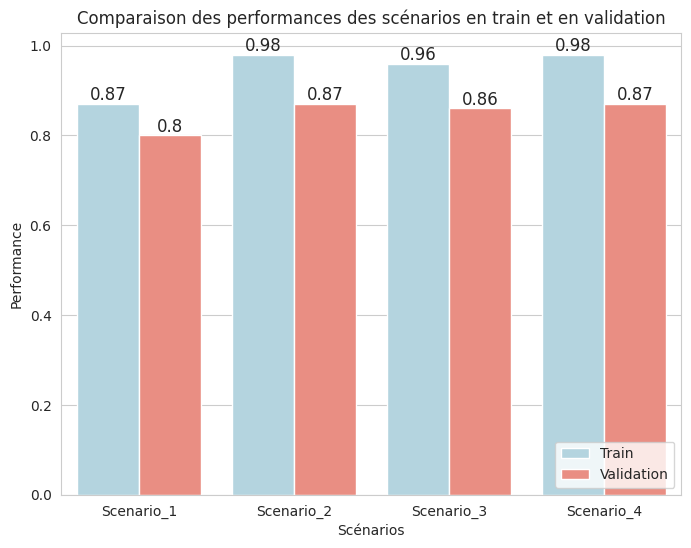

<Figure size 1000x600 with 0 Axes>

In [ ]:
df_recap = pd.DataFrame({'Modeles' : ['Scenario_1', 'Scenario_2', 'Scenario_3', 'Scenario_4'],'Train': [0.87, 0.98, 0.96, 0.98], 'Validation': [0.80, 0.87, 0.86, 0.87]})

df_recap_melted = pd.melt(df_recap, id_vars=['Modeles'], var_name='Performance', value_name='Valeur')

# Création du graphique
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Modeles', y='Valeur', hue='Performance', data=df_recap_melted, palette=['lightblue', 'salmon'], ax=ax)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=12)
ax.set_title("Comparaison des performances des scénarios en train et en validation")
ax.set_xlabel("Scénarios")
ax.set_ylabel("Performance")
ax.legend(loc='lower right')
plt.show()

#**2 - Entraînement et validation des modèles**

###**2 - a) Modèle LinearRegression**

Ensuite, nous allons appliquer le modèle de régression linéaire. 

Le Linear Régression est un modèle de régression qui cherche à établir une relation linéaire entre une variable, dite expliquée, et une ou plusieurs variables, dites explicatives.


In [ ]:

linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

#Modèle Linear
y_pred_linear_train = linear_reg.predict(X_train_scaled)
y_pred_linear_val = linear_reg.predict(X_val_scaled)

#Métriques d'évaluation pour les ensembles d'entraînement et de validation
mse_linear_train = mean_squared_error(y_train, y_pred_linear_train)
r2_linear_train = r2_score(y_train, y_pred_linear_train)
mse_linear_val = mean_squared_error(y_val, y_pred_linear_val)
r2_linear_val = r2_score(y_val, y_pred_linear_val)

#Résultats
print("Linear Regression - Train set: MSE = {:.2f}, R2 = {:.2f}".format(mse_linear_train, r2_linear_train))
print("Linear Regression - Validation set: MSE = {:.2f}, R2 = {:.2f}".format(mse_linear_val, r2_linear_val),"\n")


Linear Regression - Train set: MSE = 0.11, R2 = 0.91
Linear Regression - Validation set: MSE = 0.13, R2 = 0.89 



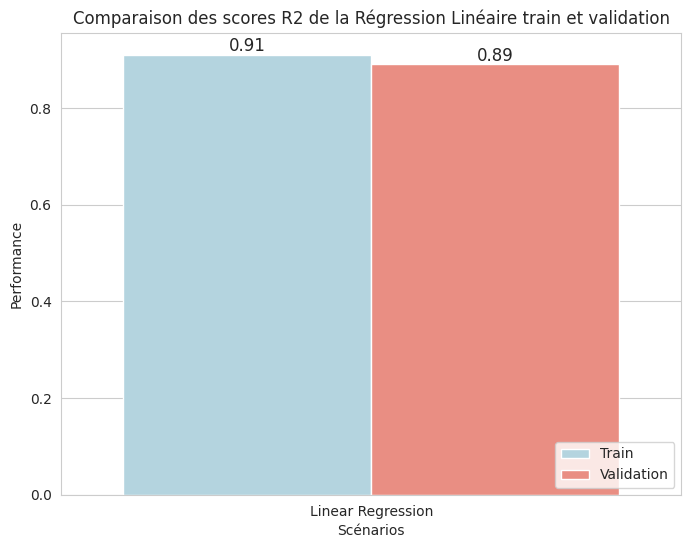

<Figure size 1000x600 with 0 Axes>

In [ ]:
df_recap = pd.DataFrame({'Modeles' : ['Linear Regression'],'Train': [0.91], 'Validation': [0.89]})

df_recap_melted = pd.melt(df_recap, id_vars=['Modeles'], var_name='Performance', value_name='Valeur')

# Création du graphique
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Modeles', y='Valeur', hue='Performance', data=df_recap_melted, palette=['lightblue', 'salmon'], ax=ax)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=12)
ax.set_title("Comparaison des scores R2 de la Régression Linéaire train et validation")
ax.set_xlabel("Scénarios")
ax.set_ylabel("Performance")
ax.legend(loc='lower right')
plt.show()


On obtient les résultats suivants :

* Linear Regression - Train set: MSE = 0.11, R2 = 0.91

* Linear Regression - Validation set: MSE = 0.13, R2 = 0.89 

Ici, le modèle Linear Regression dispose d'excellents résultats : le score R2 est élevé à 0,91 et il y a peu d'écart entre le jeu d'entraînement et de validation. A noter également que pour ce modèle, il n'y a pas de phénomène de surapprentissage.

Cependant, les résultats obtenus précédemment du Random Forest sont également satisfaisants : le R2 est à O,88, et il y a peu d'écart entre les résultats du jeu d'entraînement et de validation. 



###**2 - b) Modèles LassoRegression et RidgeRegression**

Plusieurs modèles de régression avec régularisation sont également disponibles : ElasticNet, SVR, Ridge et Lasso. 

Nous allons nous concentrer ici uniquement sur les modèles Ridge et Lasso.

* **La régression Lasso** (Least Absolute Shrinkage and Selection Operator regression) : C'est un type de méthode de régression linéaire, qui a pour objectif de minimiser la somme des erreurs quadratiques entre les valeurs prédites et réelles de la variable dépendante, sous réserve d'une contrainte sur la somme des valeurs absolues des coefficients de régression.

* **La régression Ridge** : La principale différence entre la régression Lasso et la régression de Ridge est que Lasso peut en fait définir certains coefficients sur exactement zéro, éliminant ainsi ces caractéristiques du modèle, tandis que la régression Ridge ne peut que réduire les coefficients vers zéro mais pas les définir exactement sur zéro.

In [ ]:
from sklearn.linear_model import Lasso, Ridge

#Modèle Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso_train = lasso_reg.predict(X_train_scaled)
y_pred_lasso_val = lasso_reg.predict(X_val_scaled)
mse_lasso_train = mean_squared_error(y_train, y_pred_lasso_train)
r2_lasso_train = r2_score(y_train, y_pred_lasso_train)
mse_lasso_val = mean_squared_error(y_val, y_pred_lasso_val)
r2_lasso_val = r2_score(y_val, y_pred_lasso_val)

#Modèle Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge_train = ridge_reg.predict(X_train_scaled)
y_pred_ridge_val = ridge_reg.predict(X_val_scaled)
mse_ridge_train = mean_squared_error(y_train, y_pred_ridge_train)
r2_ridge_train = r2_score(y_train, y_pred_ridge_train)
mse_ridge_val = mean_squared_error(y_val, y_pred_ridge_val)
r2_ridge_val = r2_score(y_val, y_pred_ridge_val)

#Résultats
print("Lasso Regression - Train set: MSE = {:.2f}, R2 = {:.2f}".format(mse_lasso_train, r2_lasso_train))
print("Lasso Regression - Validation set: MSE = {:.2f}, R2 = {:.2f}".format(mse_lasso_val, r2_lasso_val),"\n")
print("Ridge Regression - Train set: MSE = {:.2f}, R2 = {:.2f}".format(mse_ridge_train, r2_ridge_train))
print("Ridge Regression - Validation set: MSE = {:.2f}, R2 = {:.2f}".format(mse_ridge_val, r2_ridge_val))

Lasso Regression - Train set: MSE = 0.35, R2 = 0.73
Lasso Regression - Validation set: MSE = 0.37, R2 = 0.70 

Ridge Regression - Train set: MSE = 0.12, R2 = 0.91
Ridge Regression - Validation set: MSE = 0.14, R2 = 0.89


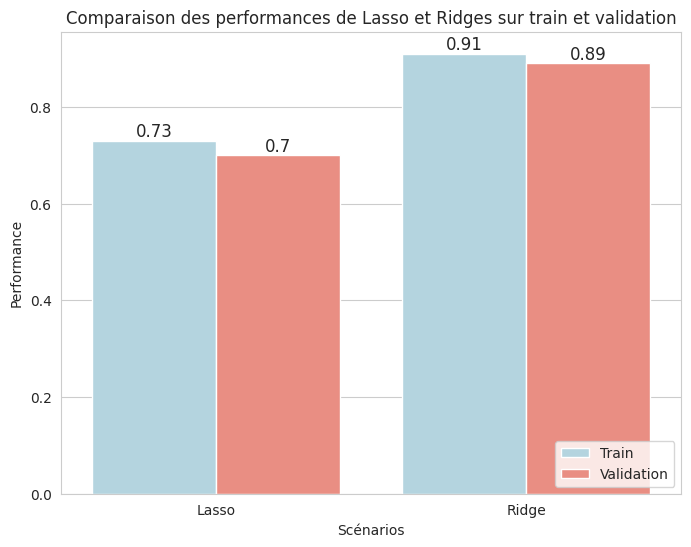

<Figure size 1000x600 with 0 Axes>

In [ ]:
df_recap = pd.DataFrame({'Modeles' : ['Lasso', 'Ridge'],'Train': [0.73, 0.91], 'Validation': [0.70, 0.89]})

df_recap_melted = pd.melt(df_recap, id_vars=['Modeles'], var_name='Performance', value_name='Valeur')

# Création du graphique
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Modeles', y='Valeur', hue='Performance', data=df_recap_melted, palette=['lightblue', 'salmon'], ax=ax)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=12)
ax.set_title("Comparaison des performances de Lasso et Ridges sur train et validation")
ax.set_xlabel("Scénarios")
ax.set_ylabel("Performance")
ax.legend(loc='lower right')
plt.show()


On obtient les résultats suivants :

* Lasso Regression - Train set: MSE = 0.35, R2 = 0.73

* Lasso Regression - Validation set: MSE = 0.37, R2 = 0.70 

* Ridge Regression - Train set: MSE = 0.12, R2 = 0.91

* Ridge Regression - Validation set: MSE = 0.14, R2 = 0.89

Ici, c'est le modèle Ridge Regression qui dispose du meilleur score : le R2 est le plus élevé à **0,91** et il y a peu d'écart entre le jeu d'entrainement et de validation.

Le modèle **Ridge Regression donne exactement les mêmes résultats que ceux du modèle Linear Regression (0,91 et 0,89)**. 

Ils sont donc à privilégier face aux modèles Lasso Regression et Random Forest qui disposent de taux de R2 plus bas, laissant penser à une moins bonne prédiction.

#**3 - Fin des itérations de tests et sélection du modèle**


##**3 - a) Boucle d'évaluation des modèles**

Suite aux différents tests précédents, nous voulions également préciser que l'ensemble du code ci-dessus peut être groupé et simplifié avec le code suivant :

In [ ]:
#Modèles à évaluer
models = {'Linear Regression': linear_reg,
          'Random Forest': forest_best_model,
          'Lasso': lasso_reg,
          'Ridge': ridge_reg}

#Boucle sur les modèles et évaluation sur l'ensemble de test
for model_name, model in models.items():
    y_pred_val = model.predict(X_val_scaled)
    mse_val = mean_squared_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)
    print(f"{model_name} - Evaluation du set de validation: MSE = {mse_val}, R2 = {r2_val}")


Linear Regression - Evaluation du set de validation: MSE = 0.13283690293655998, R2 = 0.891018344137464
Random Forest - Evaluation du set de validation: MSE = 0.2457458036183353, R2 = 0.7983859604707422
Lasso - Evaluation du set de validation: MSE = 0.3687883318041117, R2 = 0.697439776339946
Ridge - Evaluation du set de validation: MSE = 0.13935839361074978, R2 = 0.8856680022019499


On obtient les résultats suivants pour le set de validation, les mêmes que ceux obtenus auparavant :

* Lasso Regression - Validation set: MSE = 0.37, R2 = 0.70 

* Ridge Regression - Validation set: MSE = 0.14, R2 = 0.89

* Linear Regression - Validation set: MSE = 0.13, R2 = 0.89

* Random Forest - Validation set: MSE = 0.24, R2 = 0.81

**Les modèles Linear et Ridge Regression sont donc toujours bien à privilégier** pour le moment car ils disposent toujours des meilleurs scores R2.

##**3 - b) Validation croisée**

Pour comparer les modèles et leurs scores, nous avons également testé la méthode de validation croisée :


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
"""
#Il faut instancier nos 3 models
reg_lin = LinearRegression()
reg_tree = DecisionTreeRegressor(random_state=42)
reg_frt = RandomForestRegressor(random_state=42)
reg_lasso = Lasso()
reg_ridge = Ridge()

#Instancier les parametre a tester
param_grid_lin = { "fit_intercept": [True]}                                                               
param_grid_tree = {"max_depth": [5, 6, 7, 8, 9],
              "min_samples_leaf": [0.2, 0.3, 0.5, 0.6]}                                                          
param_grid_frt = { "max_features" : ["sqrt", "log2"],
            "min_samples_split" : [2,4] }
param_grid_lasso = {"alpha" : [0.1, 0.2, 0.3, 0.4, 0.5]}
param_grid_ridge = {"alpha" : [0.1, 0.2, 0.3, 0.4, 0.5]}
#dictionnaire vide gridcvs
gridcvs = {}


for pgrid, reg, name in zip((param_grid_lin, param_grid_tree, param_grid_frt,param_grid_lasso,param_grid_ridge  ),
                            (reg_lin, reg_tree, reg_frt, reg_lasso, reg_ridge ),
                            ("LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor", "Lasso", "Ridge")):
  gridcv = GridSearchCV(reg, pgrid )
  gridcvs[name] = gridcv

#KFold
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
outer_scores = {}

for name, gs in gridcvs.items():
  nested_score = cross_val_score(gs, X_train_scaled, y_train, cv=outer_cv)                                           
  outer_scores[name] = nested_score
  print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')
  """

'\n#Il faut instancier nos 3 models\nreg_lin = LinearRegression()\nreg_tree = DecisionTreeRegressor(random_state=42)\nreg_frt = RandomForestRegressor(random_state=42)\nreg_lasso = Lasso()\nreg_ridge = Ridge()\n\n#Instancier les parametre a tester\nparam_grid_lin = { "fit_intercept": [True]}                                                               \nparam_grid_tree = {"max_depth": [5, 6, 7, 8, 9],\n              "min_samples_leaf": [0.2, 0.3, 0.5, 0.6]}                                                          \nparam_grid_frt = { "max_features" : ["sqrt", "log2"],\n            "min_samples_split" : [2,4] }\nparam_grid_lasso = {"alpha" : [0.1, 0.2, 0.3, 0.4, 0.5]}\nparam_grid_ridge = {"alpha" : [0.1, 0.2, 0.3, 0.4, 0.5]}\n#dictionnaire vide gridcvs\ngridcvs = {}\n\n\nfor pgrid, reg, name in zip((param_grid_lin, param_grid_tree, param_grid_frt,param_grid_lasso,param_grid_ridge  ),\n                            (reg_lin, reg_tree, reg_frt, reg_lasso, reg_ridge ),\n                     

La validation croisée est l'une des techniques utilisée pour tester l’efficacité d’un modèle de Machine Learning via une procédure de rééchantillonnage. On utilise généralement cette méthode pour comparer différents modèles et sélectionner le plus approprié. Ici, nous avons testé plusieurs modèles avec plusieurs hyperparamètres. L'objectif est d'obtenir la moyenne des scores, ainsi que leurs écarts-types.

Plus la moyenne est élevée, et plus l'écart type est bas, plus le modèle est efficace. 

Ici, on obtient les résultats suivants avec la moyenne de score et l'écart type :

* LinearRegression : outer accuracy 86.58 +/- 1.85

* DecisionTreeRegressor : outer accuracy 65.09 +/- 5.31

* RandomForestRegressor : outer accuracy 88.11 +/- 1.69

* Lasso Regression : outer accuracy 71.71 +/- 2.16

* Ridge Regression : outer accuracy 87.09 +/- 1.84

On remarque que le Random Forest a un bon score, et a l'écart type le plus bas. Cependant, suite à nos analyses précédentes, on sait que le modèle est susceptible de développer un modèle de surapprentissage.

Ici, **nous allons donc privilégier les modèles de Régression Linéaire ou le Ridge Regression.**

##**3 - c) Analyse graphique**

Nous voulions également ajouter une vision graphique à notre phase de tests. 

En plus du score R2, la répartition des valeurs prédites selon les valeurs réelles (pour les différents modèles entrainés) est également un indicateur pertinent dans la sélection d'un modèle de prédiction. 

Nous avons donc réalisé différents graphiques pour afficher les valeurs prédites et réelles, ainsi que la droite de régression linéaire, via des nuages de points.

Linear Regression:


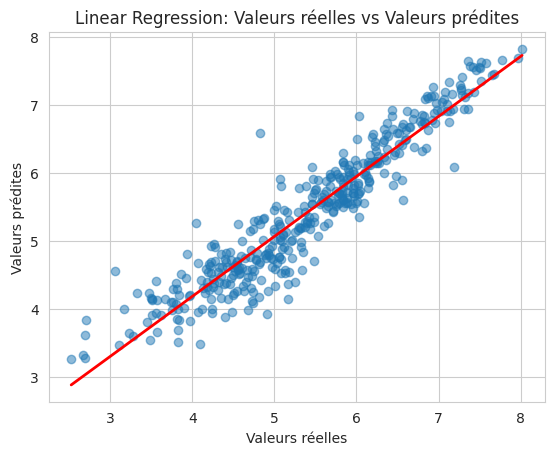

Random Forest:


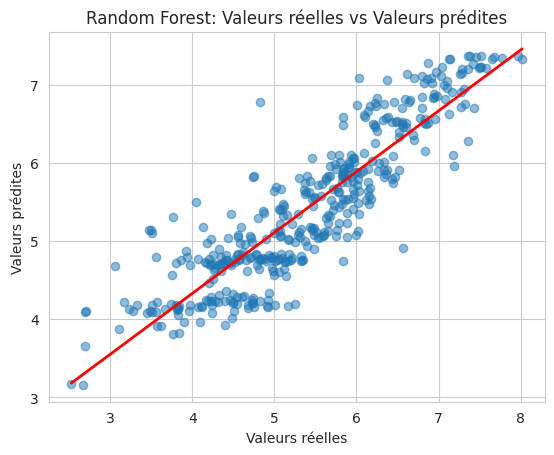

Lasso:


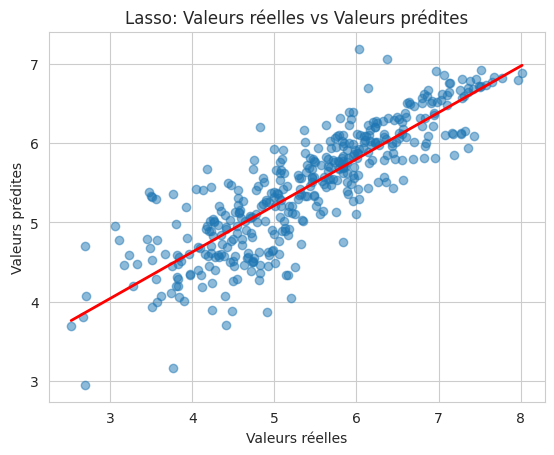

Ridge:


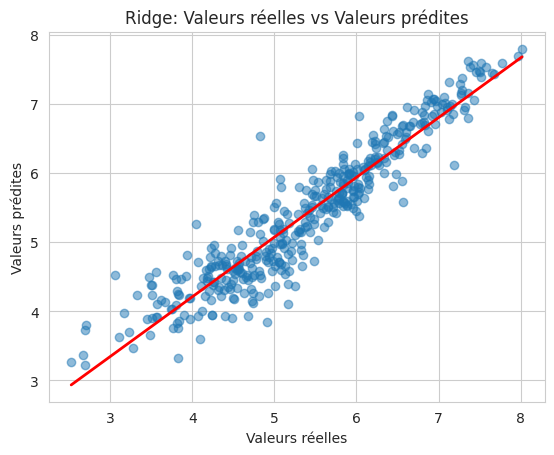

In [ ]:
import numpy as np

def plot_predictions(model_name, model, X, y):
    y_pred = model.predict(X)
    
    plt.scatter(y, y_pred, alpha=0.5)
    
    # Fit a linear regression model to the true values and predictions
    reg_line = np.polyfit(y, y_pred, 1)
    reg_func = np.poly1d(reg_line)
    
    # Create an array of x values for the regression line
    x_reg = np.linspace(y.min(), y.max(), 100)
    
    # Calculate the corresponding y values for the regression line
    y_reg = reg_func(x_reg)
    
    plt.plot(x_reg, y_reg, color='red', linewidth=2)  # Courbe de régression rouge
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Valeurs prédites')
    plt.title(f'{model_name}: Valeurs réelles vs Valeurs prédites')
    plt.show()

# Boucle sur les modèles et affichage des nuages de points avec la courbe de régression
for model_name, model in models.items():
    print(f"{model_name}:")
    plot_predictions(model_name, model, X_val_scaled, y_val)

Sur chaque graphique, les points entourent et sont proches de l'axe rouge de la régression linéaire. Les points, qui représentent les valeurs prédites et réelles, suivent la droite des nuages de points. 

Cela confirme que notre approche est bonne et que les modèles de régression linéaire sont appropriés pour notre problématique.

##**3 - d) Distribution des erreurs résiduelles**

Enfin, nous souhaitons aussi étudier les erreurs résiduelles de chaque modèle, sous forme de graphiques. 

En fonction de la distribution des erreurs, ceci peut également nous aiguiller sur la sélection d'un modèle de prédiction.

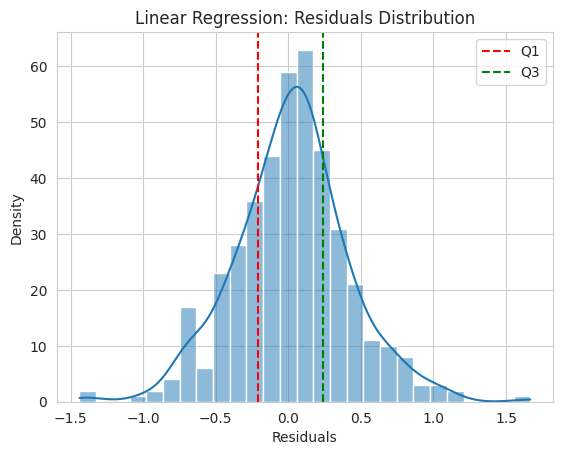

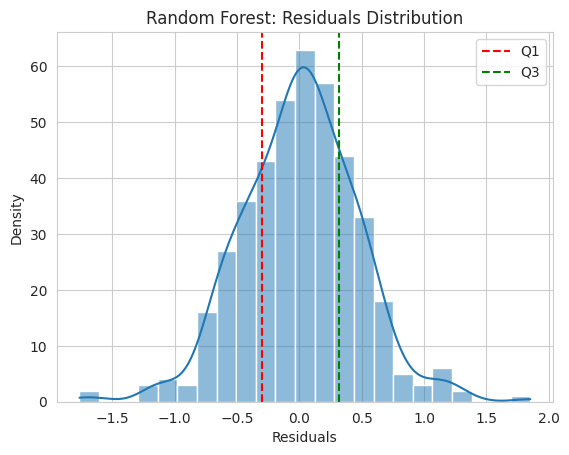

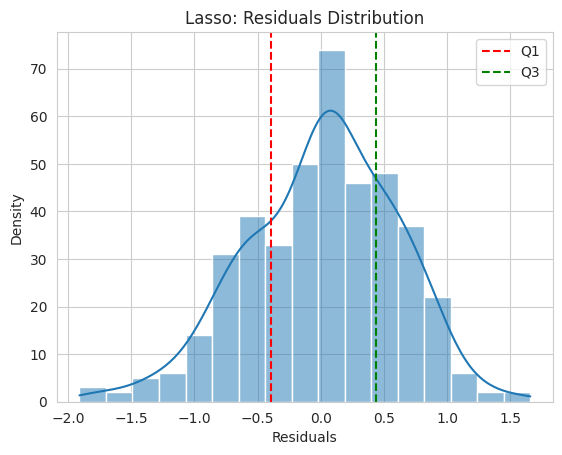

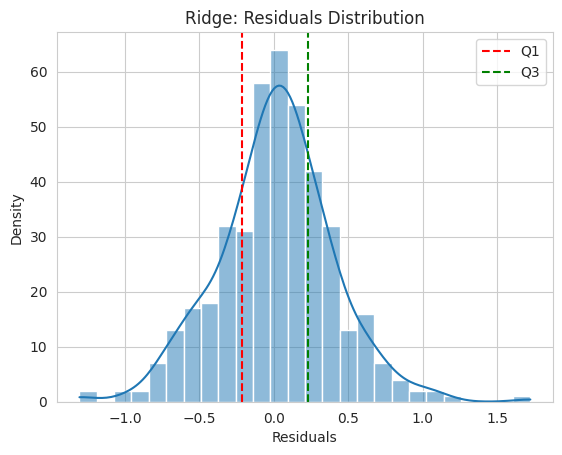

In [ ]:
#Affichage de la distribution des valeurs résiduelles

import seaborn as sns
def plot_residuals(model_name, model, X_test_scaled, y_test):
    y_pred_test = model.predict(X_test_scaled)
    residuals = y_test - y_pred_test
    std_residuals = np.std(residuals)
    q1 = np.percentile(residuals, 25)
    q3 = np.percentile(residuals, 75)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=q1, color='r', linestyle='--', label='Q1')
    plt.axvline(x=q3, color='g', linestyle='--', label='Q3')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title(f'{model_name}: Residuals Distribution')
    plt.legend()
    plt.show()

# Boucle sur les modèles et affichage des erreurs résiduelles
for model_name, model in models.items():
    plot_residuals(model_name, model, X_test_scaled, y_test)


A première vue, les graphiques et leurs courbes semblent similaires.

Cependant, en regardant en détail, nous remarquons que pour la Régression Linéaire et le Ridge Regression, la distribution des erreurs résiduelles suit parfaitement la loi normale (la courbe est harmonieuse et proche du graphique). Cela signifie que la majorité des erreurs est faible et que les erreurs importantes sont peu fréquentes.

D'autre part, nous pouvons observer que la distribution des erreurs est centrée autour du 0 pour ces deux modèles. La moyenne des erreurs est donc proche de 0, écartant la possibilité qu'il y ait un biais systématique dans l'usage des modèles Linear Régression et Ridge Régression.




##**3 - e) Récapitulatif et conclusion**

Enfin, pour plus de visibilité, nous souhaitons également comparer visuellement les modèles et les scores obtenus entre eux.

Pour rappel, voici les résultats obtenus pour l'ensemble des modèles, groupés dans un dataframe. 



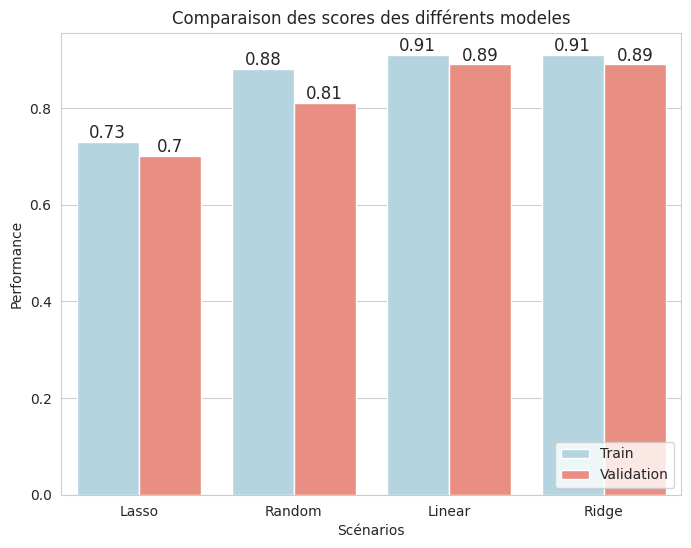

<Figure size 1000x600 with 0 Axes>

In [ ]:
df_recap = pd.DataFrame({'Modeles' : ['Lasso', 'Random', 'Linear', 'Ridge'],'Train': [ 0.73, 0.88, 0.91, 0.91], 'Validation': [0.70, 0.81, 0.89, 0.89]})

df_recap_melted = pd.melt(df_recap, id_vars=['Modeles'], var_name='Performance', value_name='Valeur')

# Création du graphique
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Modeles', y='Valeur', hue='Performance', data=df_recap_melted, palette=['lightblue', 'salmon'], ax=ax)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=12)
ax.set_title("Comparaison des scores des différents modeles")
ax.set_xlabel("Scénarios")
ax.set_ylabel("Performance")
ax.legend(loc='lower right')
plt.show()

Ce graphique nous permet de clairement visualiser le résultat de l'ensemble des modèles. 

Ici, comme précédemment expliqué, deux modèles affichent les scores les plus élevés: **le Linear Régression et le Ridge Régression**. Il nous faut donc désormais choisir entre ces deux modèles.

Au vu des analyses précédentes, et notamment des graphiques, nous avons décidé de choisir le modèle **Linear Régression**.

**En effet, le modèle dispose d'un score R2 élevé et ne crée pas de phénomène de surapprentissage. Les deux précédents graphiques ont également confirmé la cohérence du Linear Régression.
Enfin, le Linear Régression est également très approprié pour les jeux de données simples, ce qui est le cas pour notre jeu de données actuel.**

#**4 - Evaluation du modèle sur le jeu de test**

##**4 - a) Application sur le jeu de test**

Au vu des précédentes informations, nous avons donc finalement privilégié le modèle Linear Régression. 

La prochaine étape consiste donc à l'appliquer au jeu de données test.


In [ ]:
#Modèle LinearRegression
best_model = linear_reg  

#Évaluer le modèle final sur l'ensemble de test
y_pred_test = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Test set evaluation: MSE = {}, R2 = {}".format(mse_test, r2_test))


Test set evaluation: MSE = 0.15536523426675358, R2 = 0.8667510570125794


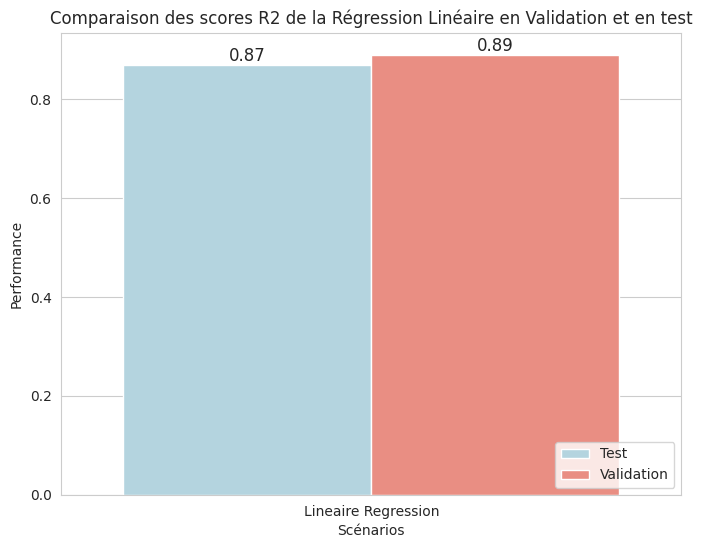

<Figure size 1000x600 with 0 Axes>

In [ ]:
df_recap = pd.DataFrame({'Modeles' : ['Lineaire Regression'],'Test': [ 0.87], 'Validation': [0.89]})

df_recap_melted = pd.melt(df_recap, id_vars=['Modeles'], var_name='Performance', value_name='Valeur')

# Création du graphique
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Modeles', y='Valeur', hue='Performance', data=df_recap_melted, palette=['lightblue', 'salmon'], ax=ax)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=12)
ax.set_title("Comparaison des scores R2 de la Régression Linéaire en Validation et en test")
ax.set_xlabel("Scénarios")
ax.set_ylabel("Performance")
ax.legend(loc='lower right')
plt.show()

Pour rappel, nous disposions d'un score R2 de **0.89** sur le jeu de validation Linear Regression. 
Le score R2 actuel pour le jeu de test est donc très proche avec **0.87**.

**Cela nous laisse penser que ce modèle fonctionne parfaitement et pourrait permettre d'obtenir des prédictions précises du "Life ladder" pour les prochaines années.**

##**4 - b) Coefficients et identification des variables clefs**


Pour mieux comprendre et interpréter le résultat précédent du modèle de régression linéaire, nous pensions qu'il était nécessaire de s'intéresser aux coefficients et de déterminer les variables qui influencent ce modèle (et ses résultats de prédictions). 

En effet, chaque coefficient représente la contribution de chaque variable indépendante (par exemple les variables "Log GDP per capita" ou "Social support") au modèle de prédiction de la variable cible (ici "Life Ladder"). 

Un coefficient positif indique une relation positive entre la variable indépendante et la variable dépendante / cible. Lorsque la variable indépendante augmente, la variable dépendante augmente également. 
Un coefficient négatif indique une relation inverse entre les deux variables, c'est-à-dire que lorsque la variable indépendante augmente, la variable dépendante diminue (et inversement).

En général, plus la valeur absolue du coefficient est grande, plus la variable indépendante est importante pour la prédiction de la variable dépendante. C'est ce que nous allons essayer de déterminer.

In [ ]:
#Coefficient de corrélation pour chacunes des 199 variables
best_model.coef_

#Récuperation des noms des variables après encodage
col_names = preprocessor.get_feature_names_out(X_test.columns)

#Création d'un dataframe provisoire pour notre graphique
df_coef = pd.DataFrame({'coef' : best_model.coef_,
                        "col" : col_names})


In [ ]:
#Récuperation uniquement des variables avant encodage
df_coef_filtered = df_coef[df_coef['col'].str.startswith('num')]

Text(0, 0.5, 'Variables')

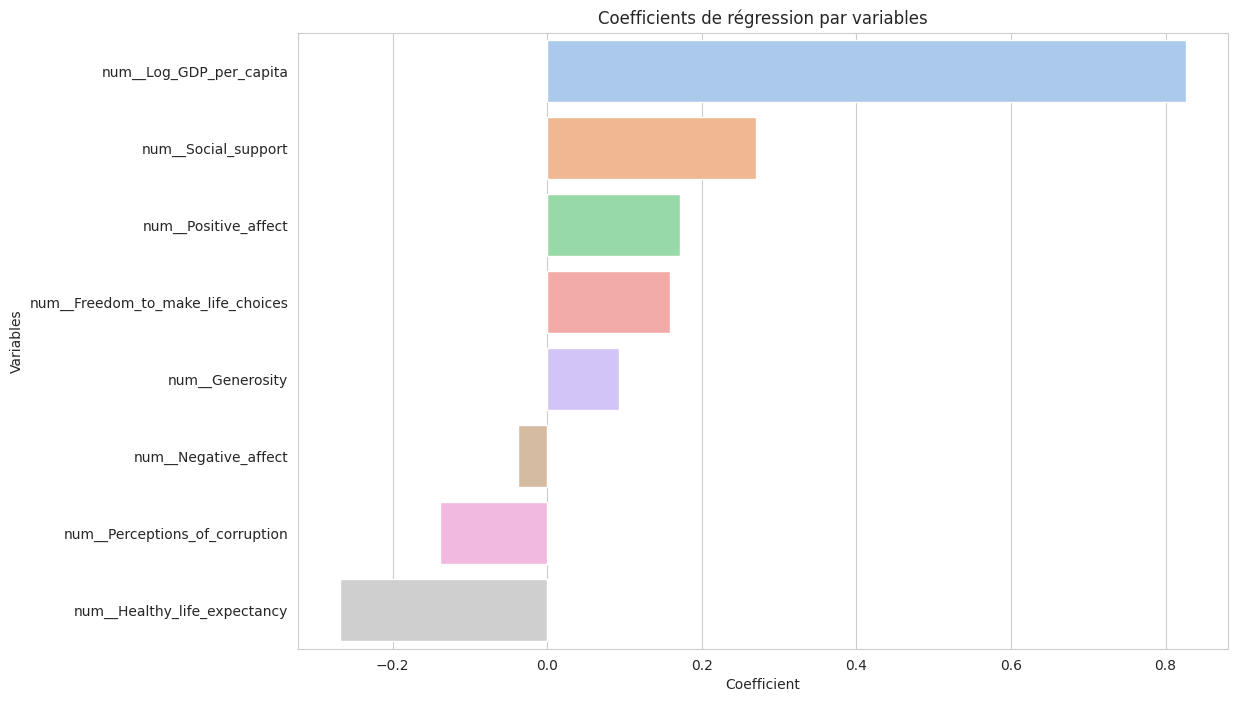

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='coef', y='col', data = df_coef_filtered.sort_values(by='coef', ascending = False), palette='pastel')
plt.title("Coefficients de régression par variables")
plt.xlabel("Coefficient")
plt.ylabel("Variables")

En général, les coefficients de régression les plus importants (en valeur absolue) indiquent les variables qui ont le plus grand impact sur la variable dépendante. 

Ici, le graphique indique donc que **les variables "Log GDP per capita" et "Social Support" ont une influence positive importante sur la variable cible "Life ladder"**. Cette influence avait déjà été mentionnée dans la première partie.

Nous pouvons également noter que certaines variables comme "Healthy life Expectancy" influencent négativement la variable cible "Life ladder", mais à moindre mesure que les variables positives précédentes.

Cependant, il faut également nuancer ces résultats et prendre en compte d'autres facteurs tels que la corrélation entre les variables indépendantes et la multicolinéarité.

#**5 - Déploiement du modèle prédictif**

Au cours du projet, un nouveau rapport a été rendu disponible. Il s'agit du rapport World Happiness Report 2023 (publié le 20 mars) avec l'ensemble des données de l'année 2022.

Nous allons donc effectuer une prédiction avec notre Linear modèle sur l'année 2022 et comparer les résultats obtenus à ceux présents dans le nouveau rapport 2023.

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*nicolascuvelliez
10c8856419a8e2f971fe6cb30bad4764*

In [ ]:
import opendatasets as od
import pandas
  
od.download("https://www.kaggle.com/datasets/ajaypalsinghlo/world-happiness-report-2023")

Skipping, found downloaded files in "./world-happiness-report-2023" (use force=True to force download)


In [ ]:
file = ('/content/world-happiness-report-2023/WHR2023.csv')
df_2022 = pd.read_csv(file)

Dans un second temps, nous devons formater et transformer à nouveau les données, comme lors de la première partie. Il doit en effet être retravaillé pour pouvoir s'appliquer aux étapes de modélisation. 

Nous avons donc modifié quelques variables non communes, ajouté les variables "Year" et "Regional Indicator", et renommé certaines colonnes (pour qu'elles correspondent à l'étape de preprocessing).

In [ ]:
#Sélection et modification des noms de colonnes
df_2022 = df_2022.drop(['upperwhisker', 'Standard error of ladder score', 'lowerwhisker', 'Ladder score in Dystopia', 'Explained by: Log GDP per capita', 'Explained by: Log GDP per capita', 'Explained by: Social support', 'Explained by: Healthy life expectancy', 
                             'Explained by: Freedom to make life choices', 'Explained by: Generosity', 'Explained by: Perceptions of corruption', 'Dystopia + residual'], axis=1)

df_2022.rename({"Ladder score" : "Life Ladder",
                     "Logged GDP per capita" : "Log GDP per capita",
                     "Healthy life expectancy" : "Healthy life expectancy at birth"}, axis=1, inplace=True)
df_2022.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
0,Finland,7.804,10.792,0.969,71.150,0.961,-0.019,0.182
1,Denmark,7.586,10.962,0.954,71.250,0.934,0.134,0.196
2,Iceland,7.530,10.896,0.983,72.050,0.936,0.211,0.668
3,Israel,7.473,10.639,0.943,72.697,0.809,-0.023,0.708
4,Netherlands,7.403,10.942,0.930,71.550,0.887,0.213,0.379


In [ ]:
#Création de l'année 2022
df_2022['year'] = 2022

#Ajout des régions par rapport aux pays du précédent dataframe df_wh
region_dict = df_wh.groupby('Country_name')['Regional_indicator'].unique().map(lambda regions: ", ".join(regions)).to_dict()

#Création et modifications des colonnes sur 2022
df_2022['Regional indicator'] = df_2022['Country name'].map(region_dict)

df_2022 = df_2022.rename({"Country name" : "Country_name",
              "Life Ladder": "Life_Ladder",
              "Regional indicator" : "Regional_indicator",
              "Log GDP per capita" : "Log_GDP_per_capita",
              "Social support" : "Social_support",
              "Healthy life expectancy at birth" : "Healthy_life_expectancy",
              "Freedom to make life choices" : "Freedom_to_make_life_choices",
              "Perceptions of corruption": "Perceptions_of_corruption"}, axis=1)

Ensuite, nous allons entrainer le modèle sur les données précédentes (de 2005 à 2021 : nous avons dû enlever les colonnes "Positive Effect" et "Negative Effect" car elles n'étaient pas présentes dans ce nouveau rapport) afin de prédire la variable cible "Life ladder" de 2022.

In [ ]:
#Préparation des jeux de données
X_2022 = df_2022.drop('Life_Ladder', axis=1)
y_2022 = df_2022['Life_Ladder']

#Récupération des donnée globales avec le preprocessing
X = X.drop(['Positive_affect', 'Negative_affect'], axis=1)

numerical_columns = X.select_dtypes(include=['int64','float64']).columns
categorical_columns = X.select_dtypes(exclude=['int64','float64']).columns

num_transform = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', RobustScaler())])

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transform, numerical_columns),
                                               ('cat', cat_transformer, categorical_columns)])

Train_Global = preprocessor.fit_transform(X)

#Entrainement
best_model.fit(Train_Global, y)

LinearRegression()

Enfin, afin de comparer les scores entre eux, nous devons réaliser une dernière étape de pré-processing sur les nouvelles données, celles de 2022, avant de passer à la prédiction.

In [ ]:
X_2022_scaled = preprocessor.transform(X_2022)
print("Score sur 2023", r2_score(y, best_model.predict(Train_Global)))

Score sur 2023 0.9026543338842227


In [ ]:
y_pred_2022 = best_model.predict(X_2022_scaled)
print("Score sur 2023", r2_score(y_2022, y_pred_2022))

Score sur 2023 0.8756718198875888


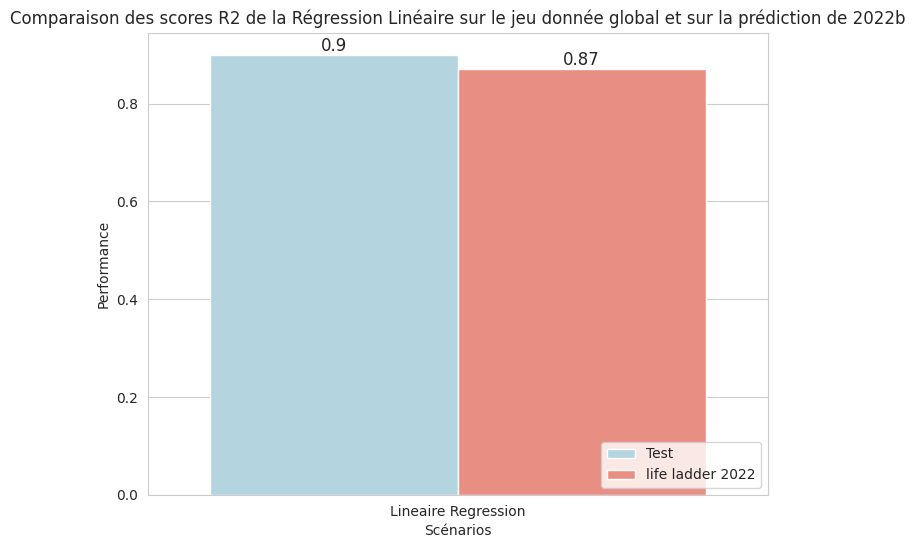

<Figure size 1000x600 with 0 Axes>

In [ ]:
df_recap = pd.DataFrame({'Modeles' : ['Lineaire Regression'],'Test': [ 0.90], 'life ladder 2022': [0.87]})

df_recap_melted = pd.melt(df_recap, id_vars=['Modeles'], var_name='Performance', value_name='Valeur')

# Création du graphique
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Modeles', y='Valeur', hue='Performance', data=df_recap_melted, palette=['lightblue', 'salmon'], ax=ax)
for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=12)
ax.set_title("Comparaison des scores R2 de la Régression Linéaire sur le jeu donnée global et sur la prédiction de 2022b")
ax.set_xlabel("Scénarios")
ax.set_ylabel("Performance")
ax.legend(loc='lower right')
plt.show()

In [ ]:
save_df(df_2022, "df_22.csv")

Nous obtenons alors un score R2 de **0,87** pour cette nouvelle prédiction, ce qui confirme que notre modèle fonctionne et est en accord avec les nouvelles données de 2022.